### Imports and Paths

In [26]:
# import libraries to read edf data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

dataset_path = r"D:\WORK\UMBC\CAP\physionet.org\files\capslpdb\1.0.0"

# read all edf files and store in a list
edf_files = []

for file in os.listdir(dataset_path):
    if file.endswith(".edf"):
        edf_files.append(file)

edf_files[:5]

['brux1.edf', 'brux2.edf', 'ins1.edf', 'ins2.edf', 'ins3.edf']

### .edf file using MNE library

In [27]:
import mne 

# read edf file using mne library
EEG_data = mne.io.read_raw_edf(dataset_path + "\\" + edf_files[12], preload=True)
# Define a list of channel names you want to keep
selected_channels = ['Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1']
# Select the channels you want to keep
EEG_data.pick_channels(ch_names=selected_channels)
print("New raw created successfully with EEG Ch only")
EEG_data

Extracting EDF parameters from D:\WORK\UMBC\CAP\physionet.org\files\capslpdb\1.0.0\n10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15052799  =      0.000 ... 29399.998 secs...
New raw created successfully with EEG Ch only


<RawEDF | n10.edf, 5 x 15052800 (29400.0 s), ~574.2 MB, data loaded>

In [28]:
# get the data in the form of dataframe
EEG_data_df = EEG_data.to_data_frame()

# show first 50 rows of the dataframe
EEG_data_df.head()

,time,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,0.000000,52.915140,17.506105,19.246032,16.071429,1.755189
1,0.001953,46.901709,21.810134,20.650183,14.606227,2.365690
2,0.003906,38.782051,27.182540,22.878510,12.500000,8.562271
3,0.005859,30.540293,32.249695,25.320513,10.180098,16.315629
4,0.007812,23.122711,36.370574,27.548840,7.738095,22.512210


In [29]:
# get the info about the data
info = EEG_data.info
channels = EEG_data.ch_names
Fs = info["sfreq"]
EpochTime = 1

# EEG_data = mne.filter.filter_data(EEG_data_arr, Fs, 1, 40, method='iir')

### Assigning annotations to the data 

In [30]:
# create function to read .txt files and return a dataframe
def read_txt(file_path):
    with open(file_path, "r") as f:
        for line in f:
            if line.strip() == "Scoring Time:":
                break

        df = pd.read_csv(f, sep="\t")
        print("filename:", file_path.split("\\")[-1])
        print("Shape of dataframe:", df.shape)
        
    return df


ann_df = read_txt(dataset_path + "\\" + edf_files[12].split(".")[0] + ".txt")

# calculate the total duration
print("Total duration:", ann_df["Duration[s]"].sum())

# # non MCAP events are renamed as NonCAP and events starting with MCAP are kept as it is
ann_df["Event"] = ann_df["Event"].apply(lambda x: "NonCAP" if x.startswith("MCAP") == False else x)

# calculate the total duration for MCAP events only (MCAP-A1, MCAP-A2, MCAP-A3)
mcap_events = ann_df[ann_df["Event"].str.startswith("MCAP")]

# Calculate total duration
total_duration = mcap_events["Duration[s]"].sum()

print("Total duration for MCAP events:", total_duration)

display(ann_df["Event"].value_counts())

display(ann_df)

filename: n10.txt
Shape of dataframe: (1111, 6)
Total duration: 28307
Total duration for MCAP events: 2747


NonCAP     852
MCAP-A1    164
MCAP-A3     61
MCAP-A2     34
Name: Event, dtype: int64

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:24:52,NonCAP,30,ROC-LOC
1,W,Unknown Position,23:25:22,NonCAP,30,ROC-LOC
2,W,Unknown Position,23:25:52,NonCAP,30,ROC-LOC
3,W,Unknown Position,23:26:22,NonCAP,30,ROC-LOC
4,W,Unknown Position,23:26:52,NonCAP,30,ROC-LOC
...,...,...,...,...,...,...
1106,S2,Unknown Position,06:32:22,NonCAP,30,ROC-LOC
1107,S2,Unknown Position,06:32:52,NonCAP,30,ROC-LOC
1108,S3,Unknown Position,06:33:22,NonCAP,30,ROC-LOC
1109,S3,Unknown Position,06:33:52,NonCAP,30,ROC-LOC


In [31]:
# get the start and end time of ann_df dataframe
start_ann_time, end_ann_time = ann_df["Time [hh:mm:ss]"].iloc[0], ann_df["Time [hh:mm:ss]"].iloc[-1]

# convert start time to datetime format using EEG_data.info["meas_date"] date only
start_ann_time = EEG_data.info["meas_date"].replace(hour=int(start_ann_time.split(":")[0]),
                                                    minute=int(start_ann_time.split(":")[1]),
                                                    second=int(start_ann_time.split(":")[2]))

print("Start time of ann_df:", start_ann_time)
print("End time of ann_df:", end_ann_time)


Start time of ann_df: 2008-01-01 23:24:52+00:00
End time of ann_df: 06:34:22


In [32]:
# create annotations using mne.Annotations
annotations = mne.Annotations(onset=ann_df["Duration[s]"].cumsum().to_list(),
                              duration=ann_df["Duration[s]"].to_list(),
                              description=ann_df["Event"].to_list(),
                              orig_time=start_ann_time)

# add the annotations to the raw data
EEG_data.set_annotations(annotations)

<RawEDF | n10.edf, 5 x 15052800 (29400.0 s), ~574.2 MB, data loaded>

In [33]:
EEG_data.annotations.orig_time

datetime.datetime(2008, 1, 1, 22, 24, 52, tzinfo=datetime.timezone.utc)

In [34]:
start_ann_time

datetime.datetime(2008, 1, 1, 23, 24, 52, tzinfo=datetime.timezone.utc)

In [35]:
EEG_data.annotations.save("saved_annotations.csv" , overwrite=True)


Overwriting existing file.


Using matplotlib as 2D backend.


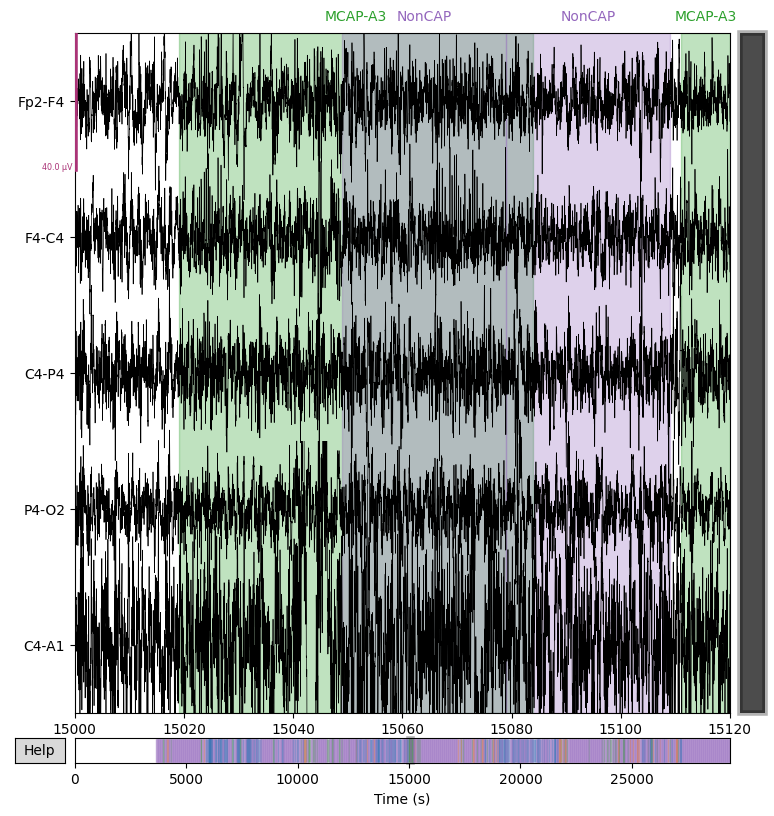

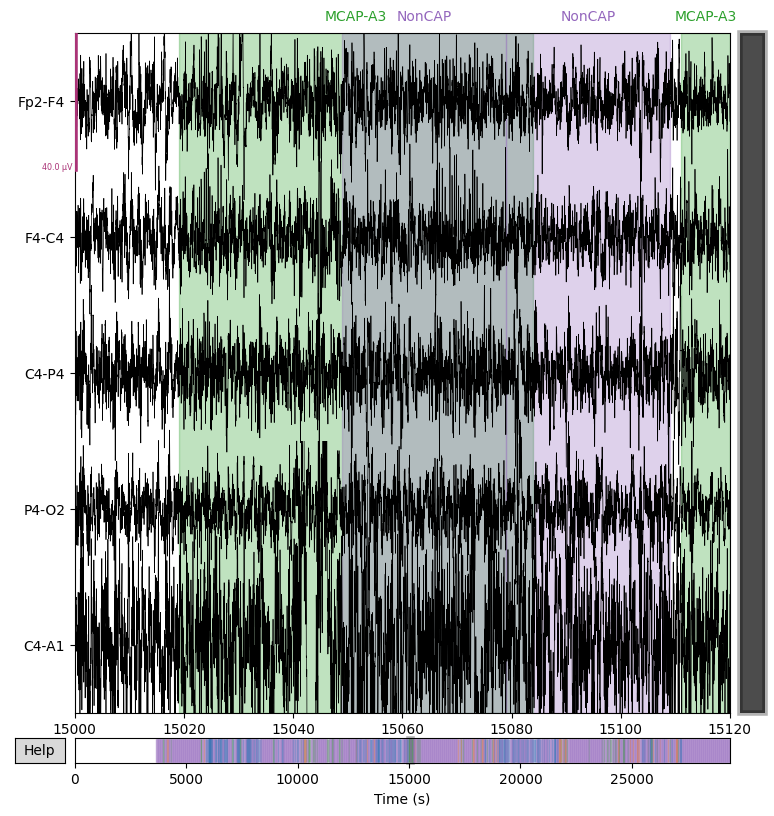

In [36]:
# plot the annotations using mne
EEG_data.plot(duration=120, show=True, start=15000)

### Labeling non annotated data as 'NonCAP'

In [37]:
# EEG_data.annotations.count()

In [38]:
EEG_data.to_data_frame()

,time,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,0.000000,52.915140,17.506105,19.246032,16.071429,1.755189
1,0.001953,46.901709,21.810134,20.650183,14.606227,2.365690
2,0.003906,38.782051,27.182540,22.878510,12.500000,8.562271
3,0.005859,30.540293,32.249695,25.320513,10.180098,16.315629
4,0.007812,23.122711,36.370574,27.548840,7.738095,22.512210
...,...,...,...,...,...,...
15052795,29399.990234,14.789377,-13.598901,-38.843101,-16.132479,-13.598901
15052796,29399.992188,17.109280,-13.141026,-38.690476,-16.620879,-15.888278
15052797,29399.994141,19.459707,-12.835775,-38.659951,-17.109280,-18.452381
15052798,29399.996094,21.749084,-12.713675,-38.751526,-17.567155,-21.260684


#### Removing non annotated data

In [39]:
EEG_data.annotations.__len__()

1024

In [40]:
# Create a list to store time intervals with annotations
annotation_intervals = []

for onset, duration, _ in zip(EEG_data.annotations.onset, EEG_data.annotations.duration, EEG_data.annotations.description):
    annotation_intervals.append((onset, onset + duration))

len(annotation_intervals), annotation_intervals[-5:]

(1024,
 [(29257.0, 29287.0),
  (29287.0, 29317.0),
  (29317.0, 29347.0),
  (29347.0, 29377.0),
  (29377.0, 29400.0)])

In [41]:
# Initialize an empty list to store data segments
data_segments = []

# Extract data segments corresponding to annotation intervals
for onset, end in annotation_intervals:
    segment, times = EEG_data[:, int(onset * Fs):int(end * Fs)]
    data_segments.append(segment)

data_segments[0].shape

(5, 15360)

In [42]:
# Concatenate the data segments
new_data = mne.io.RawArray(np.concatenate(data_segments, axis=1), EEG_data.info)

# Create a new Raw object with the concatenated data
new_raw = mne.io.RawArray(new_data.get_data(), EEG_data.info)


Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.


In [43]:
new_raw.to_data_frame()


,time,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,0.000000,-6.578144,0.198413,3.403541,-7.005495,-4.594017
1,0.001953,-6.547619,1.419414,3.006716,-8.195971,-4.594017
2,0.003906,-6.669719,2.518315,2.518315,-9.233822,-4.716117
3,0.005859,-6.791819,3.373016,2.060440,-10.149573,-4.929792
4,0.007812,-6.944444,3.983516,1.633089,-10.821123,-5.448718
...,...,...,...,...,...,...
13194235,25769.990234,14.789377,-13.598901,-38.843101,-16.132479,-13.598901
13194236,25769.992188,17.109280,-13.141026,-38.690476,-16.620879,-15.888278
13194237,25769.994141,19.459707,-12.835775,-38.659951,-17.109280,-18.452381
13194238,25769.996094,21.749084,-12.713675,-38.751526,-17.567155,-21.260684


In [44]:
pd.read_csv("saved_annotations.csv")['duration'].sum()

25770.0

In [45]:
# get the annotations from the EEG_data with shape of new_raw
EEG_data.annotations.to_data_frame()['duration'].sum()

25770.0

In [46]:
# get a list from EEG_data.annotations dataframe such that it has shape of 'duration' * 'description' 

new_label = EEG_data.annotations.to_data_frame()['description'].to_list()

new_label = [item for sublist in [[i] * int(j) for i, j in zip(new_label, EEG_data.annotations.to_data_frame()['duration'].to_list())] for item in sublist]

len(new_label)

25770

##### Great! Now we have a clean dataset with only CAP and NonCAP data with annotations. Let's explore the data a bit more.

### TSAI 

In [47]:
from tsai.all import *
import sklearn.metrics as skm

# from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.7.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.12.1+cu116
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


In [48]:
# chech new_raw data shape and new_label shape 
new_raw.__len__() / 256, len(new_label)

(51540.0, 25770)

Effective window size : 0.500 (s)


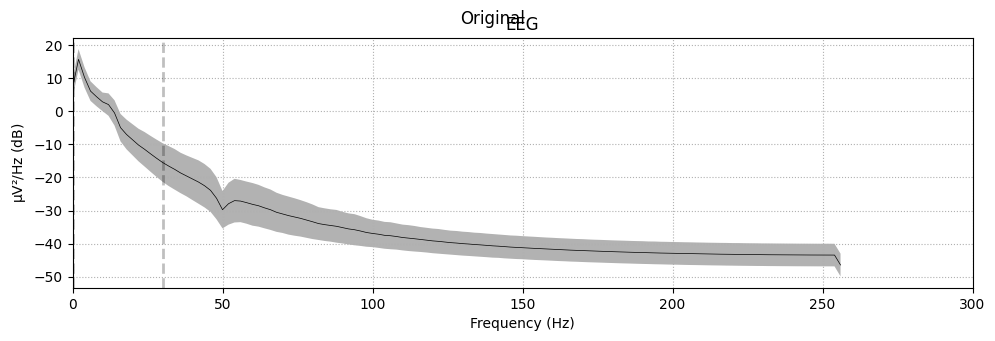

Effective window size : 1.000 (s)


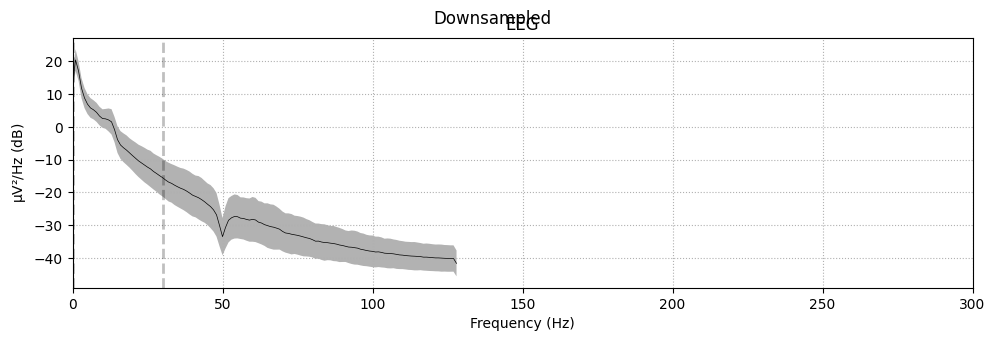

In [49]:
raw_downsampled = new_raw.copy().resample(sfreq=256)

for data, title in zip([new_raw, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, 300))
    plt.show()

In [50]:
raw_downsampled.info['sfreq']

256.0

In [51]:
# chech new_raw data shape and new_label shape 
raw_downsampled.__len__() / 256, len(new_label)

(25770.0, 25770)

### TODO: Extract features from new_raw data


In [52]:
new_data.to_data_frame()

,time,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,0.000000,-6.578144,0.198413,3.403541,-7.005495,-4.594017
1,0.001953,-6.547619,1.419414,3.006716,-8.195971,-4.594017
2,0.003906,-6.669719,2.518315,2.518315,-9.233822,-4.716117
3,0.005859,-6.791819,3.373016,2.060440,-10.149573,-4.929792
4,0.007812,-6.944444,3.983516,1.633089,-10.821123,-5.448718
...,...,...,...,...,...,...
13194235,25769.990234,14.789377,-13.598901,-38.843101,-16.132479,-13.598901
13194236,25769.992188,17.109280,-13.141026,-38.690476,-16.620879,-15.888278
13194237,25769.994141,19.459707,-12.835775,-38.659951,-17.109280,-18.452381
13194238,25769.996094,21.749084,-12.713675,-38.751526,-17.567155,-21.260684


In [53]:
eeg_data = new_data.to_data_frame().drop('time', axis=1)
eeg_data

,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,-6.578144,0.198413,3.403541,-7.005495,-4.594017
1,-6.547619,1.419414,3.006716,-8.195971,-4.594017
2,-6.669719,2.518315,2.518315,-9.233822,-4.716117
3,-6.791819,3.373016,2.060440,-10.149573,-4.929792
4,-6.944444,3.983516,1.633089,-10.821123,-5.448718
...,...,...,...,...,...
13194235,14.789377,-13.598901,-38.843101,-16.132479,-13.598901
13194236,17.109280,-13.141026,-38.690476,-16.620879,-15.888278
13194237,19.459707,-12.835775,-38.659951,-17.109280,-18.452381
13194238,21.749084,-12.713675,-38.751526,-17.567155,-21.260684


In [54]:
def abs_entropy(signal):
    """
    Calculate entropy of a signal (after taking absolute values).

    Parameters:
    signal (numpy array): Input signal for which entropy is calculated.

    Returns:
    entropy (float): Entropy of the signal.
    """
    # Take the absolute value of the signal
    abs_signal = np.abs(signal)
    
    # Calculate the probability distribution of values
    p_x = abs_signal / np.sum(abs_signal)
    
    # Calculate entropy using the modified signal
    entropy = -np.sum(p_x * np.log2(p_x))
    
    return entropy

# Example usage:
signal = np.array([-1, 2, -3, 4, -5, 6, -7, 8, -9])
ent = abs_entropy(signal)
print("Entropy (after taking absolute values):", ent)


Entropy (after taking absolute values): 2.957295041922758


In [55]:
def hjorth_parameters(signal):
    """
    Calculate Hjorth parameters for a given signal.
    
    Parameters:
    signal (numpy array): Input signal for which Hjorth parameters are calculated.
    
    Returns:
    activity (float): Activity of the signal.
    mobility (float): Mobility of the signal.
    complexity (float): Complexity of the signal.
    """
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity)
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility
    
    return activity, mobility, complexity

# Example usage:
signal = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])
act, mob, comp = hjorth_parameters(signal)
print("Activity:", act)
print("Mobility:", mob)
print("Complexity:", comp)


Activity: 1.7283950617283952
Mobility: 0.7606388292556648
Complexity: 0.9200874124564724


In [56]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Reshape the data into sequences of 512 samples
sequence_length = 512
num_sequences = len(eeg_data) // sequence_length
data_sequences = np.array_split(eeg_data.values, num_sequences)

# Initialize lists to store feature data
feature_data = {
    'Fp2-F4_Lp_Norm': [],
    'F4-C4_Lp_Norm': [],
    'C4-P4_Lp_Norm': [],
    'P4-O2_Lp_Norm': [],
    'C4-A1_Lp_Norm': [],
    'Fp2-F4_std': [],
    'F4-C4_std': [],
    'C4-P4_std': [],
    'P4-O2_std': [],
    'C4-A1_std': [],
    'Fp2-F4_skew': [],
    'F4-C4_skew': [],
    'C4-P4_skew': [],
    'P4-O2_skew': [],
    'C4-A1_skew': [],
    'Fp2-F4_kurtosis': [],
    'F4-C4_kurtosis': [],
    'C4-P4_kurtosis': [],
    'P4-O2_kurtosis': [],
    'C4-A1_kurtosis': [],
    'Fp2-F4_entropy': [],
    'F4-C4_entropy': [],
    'C4-P4_entropy': [],
    'P4-O2_entropy': [],
    'C4-A1_entropy': [],
    'Fp2-F4_hjorth_complexity': [],
    'F4-C4_hjorth_complexity': [],
    'C4-P4_hjorth_complexity': [],
    'P4-O2_hjorth_complexity': [],
    'C4-A1_hjorth_complexity': []
}

# Calculate features for each sequence
for sequence in data_sequences:
    for col in range(sequence.shape[1]):
        data = sequence[:, col]

        # Lp Norm (p = 2 for Euclidean norm)
        lp_norm = np.linalg.norm(data, ord=2)
        feature_data[eeg_data.columns[col] + '_Lp_Norm'].append(lp_norm)
        
        # Standard Deviation
        std_dev = np.std(data)
        feature_data[eeg_data.columns[col] + '_std'].append(std_dev)
        
        # Skewness
        skewness = skew(data)
        feature_data[eeg_data.columns[col] + '_skew'].append(skewness)
        
        # Kurtosis
        kurt = kurtosis(data)
        feature_data[eeg_data.columns[col] + '_kurtosis'].append(kurt)
        
        # Entropy (after taking absolute values)
        ent = abs_entropy(np.array(data))
        feature_data[eeg_data.columns[col] + '_entropy'].append(ent)
        
        # Hjorth Parameter Complexity (you may need to implement this function)
        activity, mobility, hjorth_complexity = hjorth_parameters(data)
        feature_data[eeg_data.columns[col] + '_hjorth_complexity'].append(hjorth_complexity)


# Create the features DataFrame
features_df = pd.DataFrame(feature_data)

# Display the shape of the features DataFrame
print(features_df.shape)


(25770, 30)


In [57]:
# show info of features_df
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25770 entries, 0 to 25769
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fp2-F4_Lp_Norm            25770 non-null  float64
 1   F4-C4_Lp_Norm             25770 non-null  float64
 2   C4-P4_Lp_Norm             25770 non-null  float64
 3   P4-O2_Lp_Norm             25770 non-null  float64
 4   C4-A1_Lp_Norm             25770 non-null  float64
 5   Fp2-F4_std                25770 non-null  float64
 6   F4-C4_std                 25770 non-null  float64
 7   C4-P4_std                 25770 non-null  float64
 8   P4-O2_std                 25770 non-null  float64
 9   C4-A1_std                 25770 non-null  float64
 10  Fp2-F4_skew               25770 non-null  float64
 11  F4-C4_skew                25770 non-null  float64
 12  C4-P4_skew                25770 non-null  float64
 13  P4-O2_skew                25770 non-null  float64
 14  C4-A1_

In [58]:
features_df

,Fp2-F4_Lp_Norm,F4-C4_Lp_Norm,C4-P4_Lp_Norm,P4-O2_Lp_Norm,C4-A1_Lp_Norm,Fp2-F4_std,F4-C4_std,C4-P4_std,P4-O2_std,C4-A1_std,...,Fp2-F4_entropy,F4-C4_entropy,C4-P4_entropy,P4-O2_entropy,C4-A1_entropy,Fp2-F4_hjorth_complexity,F4-C4_hjorth_complexity,C4-P4_hjorth_complexity,P4-O2_hjorth_complexity,C4-A1_hjorth_complexity
0,158.495142,153.014802,182.768237,220.930728,610.738434,5.324812,5.975124,8.070008,9.747959,22.263781,...,8.698212,8.547247,8.582828,8.611868,8.580713,3.159897,1.890279,1.590072,1.406968,2.917889
1,181.344163,123.186906,140.826592,232.226006,748.426825,7.571286,5.342043,6.057015,10.185251,32.236734,...,8.540220,8.560348,8.692980,8.663247,8.606929,3.276746,2.181420,2.006535,1.444256,3.647336
2,107.504477,121.742134,145.345849,181.126729,550.151000,4.507069,5.339306,6.401069,7.976827,24.225116,...,8.578122,8.582134,8.673627,8.606292,8.624690,2.414510,2.065085,1.924465,1.522686,4.309152
3,176.676245,168.938029,213.354674,180.894875,630.434373,7.777426,7.380757,9.420084,7.991777,27.820174,...,8.511736,8.521616,8.540414,8.580335,8.698254,2.803319,1.734142,1.500320,1.605913,3.161626
4,111.625942,137.810632,186.053174,174.207480,647.504868,4.930684,5.849091,8.216491,7.688774,28.534508,...,8.618495,8.684348,8.648927,8.607240,8.567431,2.526939,1.760329,1.536850,1.462190,3.259977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25765,129.076318,114.790383,227.751481,354.174964,486.209587,5.680408,4.711035,8.446814,14.367615,15.883341,...,8.562292,8.750778,8.747654,8.642835,8.538038,4.430944,4.093759,6.126502,12.500751,3.848239
25766,98.369221,101.396175,165.800125,143.351614,510.696450,4.048026,4.451725,7.071368,5.803959,22.096457,...,8.548097,8.589145,8.531508,8.592056,8.706369,2.631879,3.240954,3.103715,3.383733,3.960832
25767,185.680491,183.320459,134.710671,95.066952,685.702636,8.195325,8.085444,5.953033,3.810186,27.044281,...,8.623395,8.721906,8.651751,8.730669,8.794491,4.396470,4.518420,2.911122,3.896993,5.397108
25768,150.233973,97.312543,160.356315,132.292144,556.453823,6.288505,4.286714,7.083835,5.698818,15.084908,...,8.682138,8.606910,8.435336,8.513516,8.794817,2.013519,2.591590,2.479709,2.580063,1.812422


In [59]:
# apply counter to new_label

print(collections.Counter(new_label))

Counter({'NonCAP': 23063, 'MCAP-A1': 1484, 'MCAP-A3': 887, 'MCAP-A2': 336})


In [60]:
from collections import Counter
from sklearn.utils import resample

# Assuming your DataFrame of features is named 'X' and the annotations list is named 'y'
# Combine X and y into a single DataFrame
data = pd.concat([features_df, pd.Series(new_label, name='label')], axis=1)

# Get the counts of each class
class_counts = Counter(new_label)

# Determine the desired number of samples for the minority class ('MCAP' events)
desired_samples = sum(class_counts[label] for label in ['MCAP-A1', 'MCAP-A2', 'MCAP-A3'])

# Undersample the majority class ('NonCAP')
noncap_samples = data[data['label'] == 'NonCAP']
undersampled_noncap = resample(noncap_samples, n_samples=desired_samples, random_state=42)

# Combine the undersampled 'NonCAP' samples with the 'MCAP' samples
balanced_data = pd.concat([undersampled_noncap, data[data['label'].isin(['MCAP-A1', 'MCAP-A2', 'MCAP-A3'])]])

# Separate the features (X) and labels (y)
X_balanced = balanced_data.drop(columns=['label'])
y_balanced = balanced_data['label']

# Verify the class distribution
print(Counter(y_balanced))


Counter({'NonCAP': 2707, 'MCAP-A1': 1484, 'MCAP-A3': 887, 'MCAP-A2': 336})


### Train TSAI

In [66]:
# label encoding
Label_encoding = {
                'NonCAP': 0,
                "MCAP-A1": 1, 
                "MCAP-A2": 2, 
                "MCAP-A3": 3,
}

labeler = ReLabeler(Label_encoding)
y = labeler(np.array(y_balanced))

# reshape the extracted features to 2D array
X = X_balanced.to_numpy().reshape(-1, 1, X_balanced.shape[1]) ###### skipping downsample
X = X.transpose(0, 2, 1)

print(X.shape, y.shape)

(5414, 30, 1) (5414,)


In [68]:
# Assuming X is your 3D NumPy array
X_flat = X.reshape(X.shape[0], -1)
# Assuming y is your 1D NumPy array
data = np.concatenate((X_flat, y.reshape(-1, 1)), axis=1)

# Create a DataFrame
df = pd.DataFrame(data)

# set last column name as 'target'
df = df.rename(columns={df.columns[-1]: 'target'})

df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
0,161.534943,115.812376,149.523197,125.737562,326.361932,6.383980,5.080776,5.993758,5.441560,13.334041,...,8.592828,8.620392,8.549434,8.606530,2.707033,2.515820,2.345121,3.877341,1.837938,0.0
1,81.293572,113.055507,117.738473,85.513660,199.554137,3.193478,4.996385,4.160307,3.557587,8.180045,...,8.585476,8.615213,8.590374,8.525015,1.833186,3.180251,2.265776,2.974015,2.085197,0.0
2,264.175384,384.018887,338.399503,242.180210,524.468773,9.224209,16.965348,14.451398,7.215260,20.658999,...,8.622749,8.663707,8.741108,8.655191,1.644021,2.974417,2.296986,1.749847,1.823598,0.0
3,90.413409,95.899823,118.966536,209.430822,219.151378,3.900435,4.229497,4.515716,8.895166,8.820824,...,8.620810,8.492790,8.729196,8.632372,2.378197,2.525561,3.347991,6.143783,2.819218,0.0
4,240.194089,261.561276,271.744064,271.708947,939.670853,10.448365,11.359157,9.407565,9.632177,23.643998,...,8.515063,8.756577,8.606068,8.733095,1.551166,1.935330,2.332412,2.984363,2.375979,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,103.538537,119.767236,103.515406,125.577987,291.227205,4.530322,5.009569,4.547428,5.327363,12.840546,...,8.455536,8.460132,8.733167,8.719623,3.587971,3.880894,4.183947,4.071286,3.639470,1.0
5410,124.447064,126.263113,75.317629,133.042175,315.029614,5.461570,5.569853,3.154598,5.610741,13.559591,...,8.518456,8.702692,8.664302,8.595460,2.558716,2.442637,2.201331,3.287109,2.191580,1.0
5411,135.576524,115.325706,108.812918,112.105526,291.836077,5.722394,5.086816,4.309613,4.931169,12.269841,...,8.644192,8.635403,8.469193,8.584766,2.982212,2.928787,2.200906,3.208034,2.446473,1.0
5412,86.033032,130.085841,132.847970,139.660611,287.371901,3.784582,5.726457,5.495352,4.808506,12.215124,...,8.611127,8.668738,8.505802,8.583289,2.395566,2.185447,2.058097,2.734331,2.567137,1.0


In [68]:
label_counts = collections.Counter(y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {0: 2707, 3: 887, 2: 336, 1: 1484}
Naive Accuracy: 50.00%


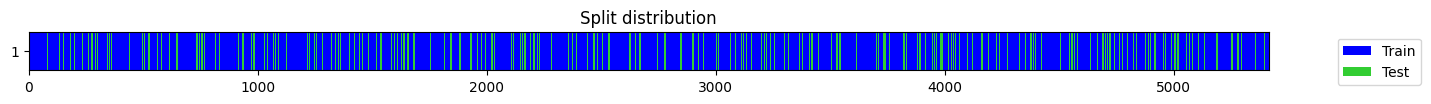

(#4332) [(TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:30, len:1, device=cpu, dtype=torch.float32), TensorCategory(0))] ...]

In [95]:
# get dataloaders
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()

splits = get_splits(y,
                    n_splits=1,
                    shuffle=True,
                    check_splits=True)

dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

In [96]:
model = build_ts_model(InceptionTimePlus, dls=dls)
learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat())

In [97]:
learn.lr_find()

SuggestedLRs(valley=0.0014454397605732083)

In [98]:
learn.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.183449,1.195292,0.503697,00:01
1,1.159609,1.140329,0.503697,00:02
2,1.142515,1.142833,0.505545,00:01
3,1.127187,1.127300,0.503697,00:01
4,1.111363,1.123206,0.502773,00:01


In [99]:
# Get predictions
dls = learn.dls
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)

# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [100]:
learn.show_results(sharey=True)


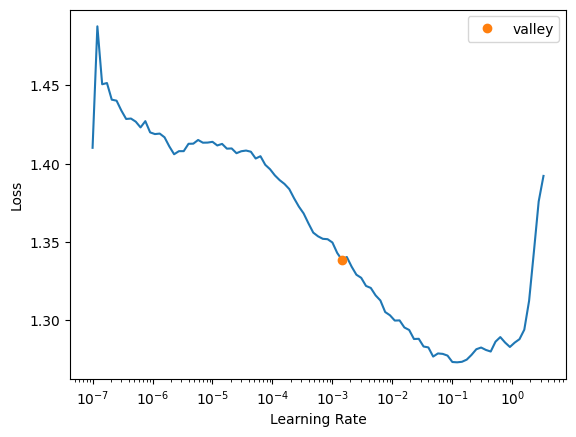

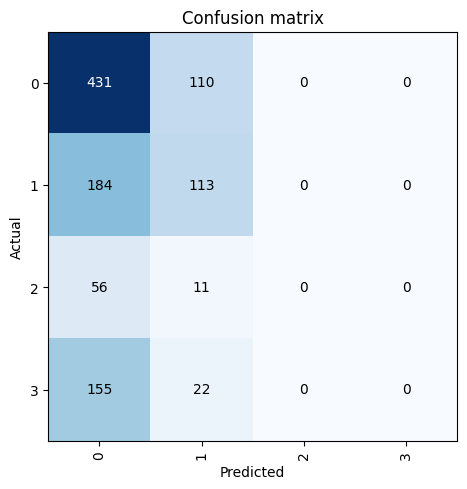

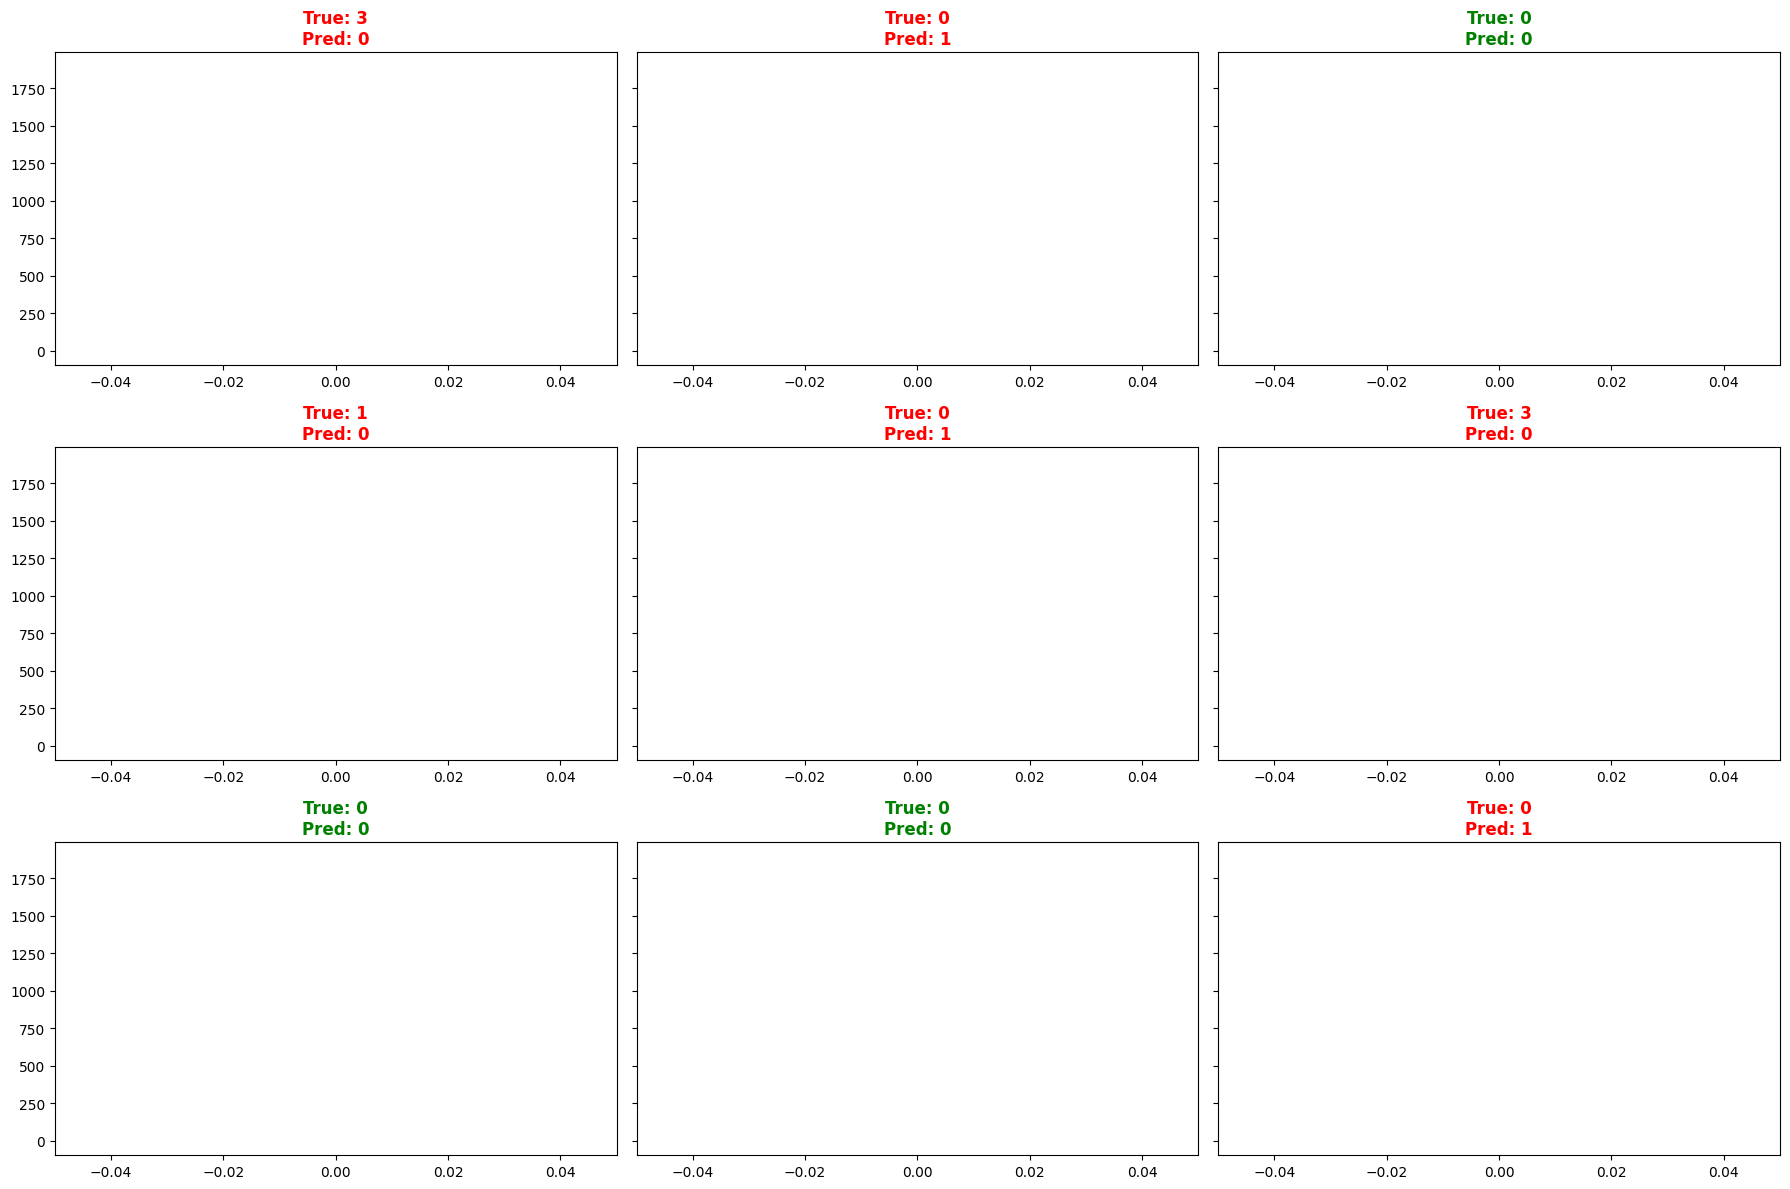

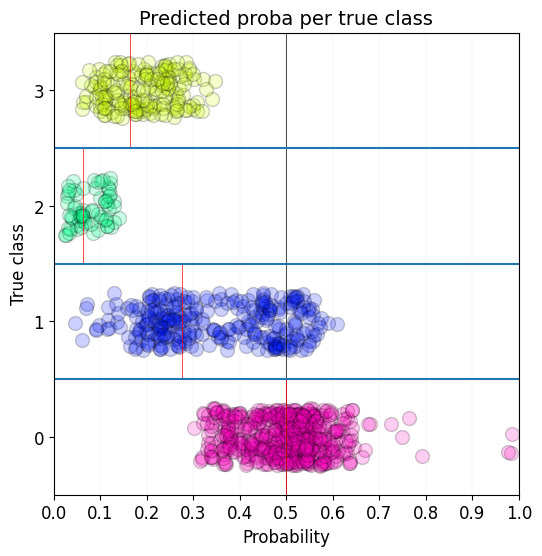

In [101]:
learn.show_probas()


In [102]:
Label_encoding

{'NonCAP': 0, 'MCAP-A1': 1, 'MCAP-A2': 2, 'MCAP-A3': 3}

### TS Archs Comparison

In [104]:
bs = 64
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_balanced, y_balanced, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

archs = [(FCN, {}), 
         (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
     

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,mWDN,{'levels': 4},457840,1.074129,1.127550,0.510166,217
1,LSTM,"{'n_layers': 1, 'bidirectional': False}",41604,1.078315,1.116161,0.507394,41
2,LSTM,"{'n_layers': 2, 'bidirectional': False}",122404,1.079387,1.133926,0.507394,51
3,LSTM,"{'n_layers': 1, 'bidirectional': True}",83204,1.094625,1.123657,0.500924,47
4,LSTM,"{'n_layers': 3, 'bidirectional': False}",203204,1.081575,1.132103,0.500000,56
5,FCN,{},264580,1.082554,1.124679,0.496303,56
6,XceptionTime,{},399480,1.031194,1.140885,0.494455,180
7,InceptionTime,{},388868,0.881396,1.262390,0.493531,191
8,LSTM,"{'n_layers': 2, 'bidirectional': True}",324804,1.069162,1.132808,0.492606,68
9,LSTM_FCN,{'shuffle': False},306180,1.079292,1.117827,0.492606,73


### PyCaret

In [138]:
# check installed version
import pycaret
pycaret.__version__

'3.0.4'

In [144]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(balanced_data, target = 'label', session_id = 42, index=False, fold = 5, fold_shuffle = True,
          normalize=True, pca=True)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Multiclass
3,Target mapping,"MCAP-A1: 0, MCAP-A2: 1, MCAP-A3: 2, NonCAP: 3"
4,Original data shape,"(5774, 31)"
5,Transformed data shape,"(5774, 31)"
6,Transformed train set shape,"(4041, 31)"
7,Transformed test set shape,"(1733, 31)"
8,Numeric features,30
9,Preprocess,True


In [146]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5311,0.5000,0.5311,0.2820,0.3684,0.0000,0.0000,0.1300
ridge,Ridge Classifier,0.5224,0.0000,0.5224,0.3837,0.4098,0.0310,0.0484,0.1100
rf,Random Forest Classifier,0.5209,0.6295,0.5209,0.4117,0.4390,0.0759,0.0918,0.1920
lr,Logistic Regression,0.5207,0.5749,0.5207,0.3821,0.4093,0.0304,0.0466,1.1020
lda,Linear Discriminant Analysis,0.5204,0.5780,0.5204,0.3874,0.4179,0.0405,0.0577,0.1180
gbc,Gradient Boosting Classifier,0.5184,0.6007,0.5184,0.4189,0.4342,0.0671,0.0829,2.1200
et,Extra Trees Classifier,0.5162,0.6154,0.5162,0.3956,0.4281,0.0560,0.0705,0.2620
ada,Ada Boost Classifier,0.5127,0.5510,0.5127,0.4352,0.4374,0.0682,0.0811,0.2560
catboost,CatBoost Classifier,0.5113,0.6194,0.5113,0.4314,0.4448,0.0794,0.0907,7.0380
lightgbm,Light Gradient Boosting Machine,0.4981,0.6128,0.4981,0.4120,0.4325,0.0585,0.0662,0.5600


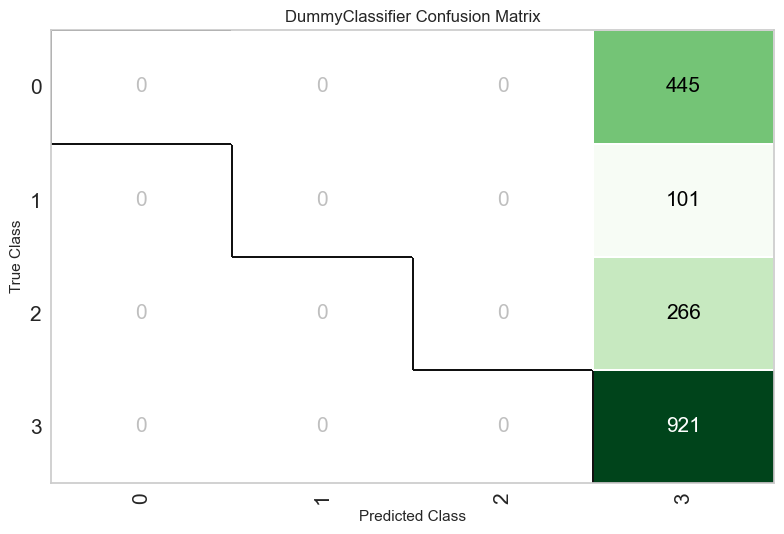

In [147]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')